In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load dataset
df = pd.read_csv('/content/data.csv')

In [4]:
df.head()

,Unnamed: 0,cc_num,category,amt,gender,is_fraud,age,trans_month,trans_year,lat_dis,long_dis
0,0,2.703190e+15,misc_net,4.97,0,0,30,1,2019,0.067507,0.870215
1,1,6.304230e+11,grocery_pos,107.23,0,0,40,1,2019,0.271247,0.024038
2,2,3.885950e+13,entertainment,220.11,1,0,56,1,2019,0.969904,0.107519
3,3,3.534090e+15,gas_transport,45.00,1,0,52,1,2019,0.803731,0.447271
4,4,3.755340e+14,misc_pos,41.96,1,0,32,1,2019,0.254299,0.830441


In [5]:
df.shape

(4850, 11)

In [6]:
df.columns

Index(['Unnamed: 0', 'cc_num', 'category', 'amt', 'gender', 'is_fraud', 'age',
       'trans_month', 'trans_year', 'lat_dis', 'long_dis'],
      dtype='object')

In [7]:
#type for each columns in datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4850 entries, 0 to 4849
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   4850 non-null   int64  
 1   cc_num       4850 non-null   float64
 2   category     4850 non-null   object 
 3   amt          4850 non-null   float64
 4   gender       4850 non-null   int64  
 5   is_fraud     4850 non-null   int64  
 6   age          4850 non-null   int64  
 7   trans_month  4850 non-null   int64  
 8   trans_year   4850 non-null   int64  
 9   lat_dis      4850 non-null   float64
 10  long_dis     4850 non-null   float64
dtypes: float64(4), int64(6), object(1)
memory usage: 416.9+ KB


In [8]:
df.describe()

,Unnamed: 0,cc_num,amt,gender,is_fraud,age,trans_month,trans_year,lat_dis,long_dis
count,4850.000000,4.850000e+03,4850.000000,4850.000000,4850.000000,4850.00000,4850.0,4850.0,4850.000000,4850.000000
mean,2424.500000,2.973469e+17,124.218249,0.338557,0.271753,49.48000,1.0,2019.0,0.509902,0.500396
std,1400.218733,1.118060e+18,170.548263,0.473268,0.444909,17.58814,0.0,0.0,0.275157,0.275451
min,0.000000,6.041621e+10,1.030000,0.000000,0.000000,13.00000,1.0,2019.0,0.000066,0.000352
25%,1212.250000,3.401870e+14,11.520000,0.000000,0.000000,34.00000,1.0,2019.0,0.322686,0.232301
50%,2424.500000,2.284565e+15,57.780000,0.000000,0.000000,49.00000,1.0,2019.0,0.486717,0.545954
75%,3636.750000,4.826660e+15,183.075000,1.000000,1.000000,58.00000,1.0,2019.0,0.778758,0.683791
max,4849.000000,4.992350e+18,3178.510000,1.000000,1.000000,92.00000,1.0,2019.0,0.999906,0.999807


In [9]:
df.value_counts("is_fraud")

,count
is_fraud,
0,3532
1,1318


In [10]:
# Define feature types
numeric_features = ['cc_num', 'amt', 'gender', 'age', 'trans_month','trans_year', 'lat_dis', 'long_dis']
categorical_features = ['category']
target = 'is_fraud'

# Encode target variable
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

# Define Preprocessing Pipelines
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

# Split dataset
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [11]:
# ============================
# 📌 LSTM Model
# ============================

# Reshape input for LSTM (batch_size, timesteps, features)
X_train_lstm = np.array(X_train_transformed, dtype=np.float32).reshape(-1, 1, X_train_transformed.shape[1])
X_test_lstm = np.array(X_test_transformed, dtype=np.float32).reshape(-1, 1, X_test_transformed.shape[1])

# Define LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(1, X_train_transformed.shape[1])),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(32, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),

    Dense(16, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test_lstm, y_test))

# Evaluate LSTM
lstm_preds = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32").flatten()
lstm_accuracy = accuracy_score(y_test, lstm_preds)
print(f"LSTM Model Accuracy: {lstm_accuracy * 100:.2f}%")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6917 - loss: 0.5997 - val_accuracy: 0.7289 - val_loss: 0.6026
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9351 - loss: 0.2779 - val_accuracy: 0.7278 - val_loss: 0.4888
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9645 - loss: 0.1517 - val_accuracy: 0.7278 - val_loss: 0.3589
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9683 - loss: 0.1179 - val_accuracy: 0.9392 - val_loss: 0.1436
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9862 - loss: 0.0688 - val_accuracy: 0.9928 - val_loss: 0.0475
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9799 - loss: 0.0644 - val_accuracy: 0.9938 - val_loss: 0.0232
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9804 - loss: 0.0562 - val_accuracy: 0.9948 - val_loss: 0.0135
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9854 - loss: 0.0480 - val_accuracy: 0.9979 - va

In [12]:
# ============================
# 📌 ANN Model
# ============================

# Define ANN Model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_transformed.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile ANN Model
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train ANN Model
ann_model.fit(X_train_transformed, y_train, epochs=20, batch_size=16, verbose=1)

# Evaluate ANN Model
ann_preds = (ann_model.predict(X_test_transformed) > 0.5).astype("int32").flatten()
ann_accuracy = accuracy_score(y_test, ann_preds)
print(f"ANN Model Accuracy: {ann_accuracy * 100:.2f}%")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8447 - loss: 0.3312
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9885 - loss: 0.0518
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9952 - loss: 0.0202
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9975 - loss: 0.0120
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9974 - loss: 0.0114
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.0076
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9984 - loss: 0.0060
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9975 - loss: 0.0074
Epoch 9/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9991 - loss: 0.0043
Epoch 10/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9994 - loss: 0.0041
Epoch 11/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.0038
Epoch 12/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [13]:
# ============================
# 📌 Hybrid LSTM + RF Model
# ============================

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_transformed, y_train)

# Extract RF Features
rf_train_features = rf_model.apply(X_train_transformed)
rf_test_features = rf_model.apply(X_test_transformed)

# Extract LSTM Features
lstm_train_features = lstm_model.predict(X_train_lstm)
lstm_test_features = lstm_model.predict(X_test_lstm)

# Concatenate RF and LSTM features
X_train_hybrid = np.concatenate((rf_train_features, lstm_train_features), axis=1)
X_test_hybrid = np.concatenate((rf_test_features, lstm_test_features), axis=1)

# Train Final Hybrid Model (RF on Hybrid Features)
hybrid_model = RandomForestClassifier(n_estimators=100, random_state=42)
hybrid_model.fit(X_train_hybrid, y_train)

# Evaluate Hybrid Model
final_preds = hybrid_model.predict(X_test_hybrid)
hybrid_accuracy = accuracy_score(y_test, final_preds)
print(f"Hybrid RF + LSTM Model Accuracy: {hybrid_accuracy * 100:.2f}%")

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Hybrid RF + LSTM Model Accuracy: 99.90%


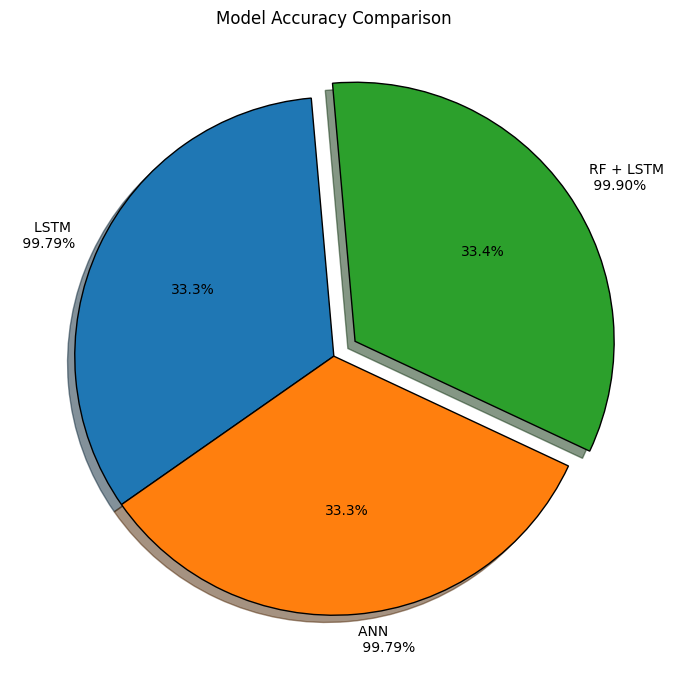

In [14]:
# ============================
# 📌 PART 4: Visualization of Accuracies
# ============================

# Define accuracy values
slices = [lstm_accuracy * 100, ann_accuracy * 100, hybrid_accuracy * 100]
labels = [f'LSTM \n {lstm_accuracy * 100:.2f}%',
          f'ANN \n {ann_accuracy * 100:.2f}%',
          f'RF + LSTM \n {hybrid_accuracy * 100:.2f}%']
explode = [0, 0, 0.1]  # Emphasizing Hybrid Model

# Plot Pie Chart
plt.figure(figsize=(7,7))
plt.pie(slices, labels=labels, explode=explode, shadow=True, startangle=95,
        wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')

plt.title('Model Accuracy Comparison')
plt.tight_layout()
plt.show()

In [15]:
# ============================
# 📌 Save Hybrid Model
# ============================

# Save the trained Hybrid Model using Pickle
Hybrid_pkl_filename = 'Hybrid.pkl'
with open(Hybrid_pkl_filename, 'wb') as Hybrid_Model_pkl:
    pickle.dump(hybrid_model, Hybrid_Model_pkl)

print("Hybrid Model saved successfully!")


Hybrid Model saved successfully!
